In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import os
# os.chdir('/content/drive/MyDrive/DAIV_2024_Fall/PromptMRG')
# %pwd

'/content/drive/MyDrive/DAIV_2024_Fall/PromptMRG'

In [11]:
#!git clone https://github.com/Hyunnji-Lee/PromptMRG.git

# medpix_data json파일 만들기

In [17]:
import json

Descriptions_file_path = 'Descriptions.json'
with open(Descriptions_file_path, 'r', encoding='utf-8') as f:
    descriptions_data = json.load(f)

Case_file_path = 'Case_topic.json'
with open(Case_file_path, 'r', encoding='utf-8') as f:
    case_data = json.load(f)

In [18]:
# 흉부 데이터 거르기 (334개)
filtered_descriptions = [data for data in descriptions_data if data['Location Category']=='Thorax']

### 질병 labels 관련

In [19]:
filtered_cases = []
id = [description['U_id'] for description in filtered_descriptions]

for case in case_data:
  if case['U_id'] in id:
      filtered_cases.append(case)

In [20]:
print(len(filtered_cases))

132


In [21]:
ex_description = filtered_cases[0]
ex_findings = [ex_description["Case"]["Findings"]]
print(ex_findings)

['•  PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign.\n\n•  Lateral chest radiograph shows anterior displacement of the major fissure and elevation of the left mainstem bronchus.\n\n•  CT of the chest reveals an obstructing mass and resultant LUL collapse.']


In [13]:
from modules.chexbert import CheXbert
import torch

checkpoint = r'C:\Users\user1\Desktop\DAIV_2024_Fall\PromptMRG\checkpoints\stanford\chexbert\chexbert.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
chexbert = CheXbert(checkpoint_path=checkpoint, device=device)
output = chexbert(ex_findings)
print(output)

tensor([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


#### case 내 질병 확인용

In [49]:
from collections import Counter

title = [case['Topic']['Title'] for case in filtered_cases]
Counter(title)

Counter({'Lung, lobar collapse (left upper lobe)': 1,
         'Adenocarcinoma of the Lung': 1,
         'Interstital Lung Disease': 1,
         'Pericardial cyst': 1,
         'Idiopathic Pulmonary Hemosiderosis': 1,
         'Pulmonary Embolism': 3,
         'thoracic aortic dissection': 1,
         'Bronchial Carcinoid': 2,
         "Takayasu's Arteritis": 1,
         'Pulmonary Hamartoma': 2,
         'Lung Metastasis': 1,
         'Sarcoid': 1,
         'Pyopneumothorax': 1,
         'Metastatic Adenocarcinoma of the Lung': 1,
         'Swyer-James Syndrome': 1,
         'Reactivation TB': 1,
         'Bronchiectasis - Bronchial Artery Embolization.': 1,
         'Pancoast tumor': 1,
         'Ascending thoracic aortic aneurysm': 1,
         'Pulmonary Embolus': 1,
         'Left aortic arch with aberrant right subclavian artery': 3,
         'Coarctation of the Aorta': 2,
         'Benign Metastasizing Leiomyoma': 1,
         'Cryptococcal Pneumonia in an Immunocompetent Host': 1

In [51]:
count = list(Counter(title))
len(count)

121

In [31]:
reports=[]
for data in filtered_descriptions:
    id = data['U_id']
    findings = [case["Case"]["Findings"] for case in case_data if case["U_id"] == id]
    report = findings
    reports.append(report)
print(reports[:50])

[['•  PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign.\n\n•  Lateral chest radiograph shows anterior displacement of the major fissure and elevation of the left mainstem bronchus.\n\n•  CT of the chest reveals an obstructing mass and resultant LUL collapse.'], ['•  PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign.\n\n•  Lateral chest radiograph shows anterior displacement of the major fissure and elevation of the left mainstem bronchus.\n\n•  CT of the chest reveals an obstructing mass and resultant LUL collapse.'], ['Chest PA/LAT revealed increased interstitial markings in the right lower lobe.\n\nContrast enhanced chest CT revealed diffuse increased interstitial markings involving the right middle and lower lobes, pleural thickening/scarring of the posterior right lower lobe, and a small right-sided pleural effusion.'], ['Chest PA/LAT revealed incre

### clip indices 관련

In [4]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl (273 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Cloning https://github.com/openai/CLIP.git to c:\users\user1\appdata\local\temp\pip-req-build-3h88mg76
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp312-cp312-win_amd64.whl.metadata (6.2 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Usi

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\user1\AppData\Local\Temp\pip-req-build-3h88mg76'


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

tensor([[ 0.0547, -0.0061,  0.0495,  ..., -0.6638, -0.1281, -0.4950],
        [ 0.1447,  0.0225, -0.2909,  ..., -0.4472, -0.3420,  0.1798],
        [ 0.1981, -0.2040, -0.1533,  ..., -0.4514, -0.5664,  0.0596]])


In [ ]:
print(text_features.shape)

torch.Size([3, 512])


In [ ]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
text_features = text_embedding

image_path = '/content/drive/MyDrive/DAIV_2024_Fall/PromptMRG/data/medpix/images/MPX1007_synpic46719.png'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(21)

print(indices)

tensor([ 30446,  30447, 195450, 195449,  15025,  15026,  37231,  37232, 262662,
        262663, 125199, 125200,  10208,  10207,  10206, 195458, 140842, 140841,
         78025,  78024,  78022])


### json 파일 만들기

In [1]:
import json
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [2]:
# clip_text_feature 가져오기
clip_text_feature_path = '../mimic_cxr/clip_text_features.json'
with open(clip_text_feature_path, 'r', encoding='utf-8') as f:
    clip_text_feature = json.load(f)
text_features = torch.tensor(clip_text_feature)

In [3]:
import sys
import os

sys.path.append(r'C:\Users\user1\Desktop\DAIV_2024_Fall\PromptMRG')

from modules.chexbert import CheXbert
import torch

checkpoint = r'C:\Users\user1\Desktop\DAIV_2024_Fall\PromptMRG\checkpoints\stanford\chexbert\chexbert.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
chexbert = CheXbert(checkpoint_path=checkpoint, device=device)

c:\Users\user1\Desktop\DAIV_2024_Fall\PromptMRG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user1\Desktop\DAIV_2024_Fall\PromptMRG\modules\chexbert.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_sa

In [7]:
import re

all_data = []

for data in filtered_descriptions:
    each_data = {}
    
    # id & image_id
    id = data['U_id']
    image_id = data['image']

    each_data['id'] = id
    
    # type
    each_data['type'] = data['Type']
    
    # image_path
    each_data['image_path'] = []
    image_path = data['image'] + '.png'
    each_data['image_path'].append(image_path)

    # report
    findings = [case["Case"]["Findings"] for case in case_data if case["U_id"] == id]
    report = findings[0]
    
    # 불필요한 문자 제거
    report = report.replace("\n", " ")
    report = report.replace("\t", " ")
    report = report.replace('\u201c', '').replace('\u201d', '').replace('\u2022', '')
    report = re.sub(r'\s+', ' ', report)
        
    each_data['report'] = report

    # clip_indices
    image_path = './images/' + image_id + '.png'

    # image encoding
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    # Pick the top 21 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(21)
    
    each_data['clip_indices'] = indices.tolist()
    
    # split
    each_data['split'] = 'test'

    # labels
    labels = chexbert(findings).tolist()
    each_data['labels'] = labels[0]
    
    all_data.append(each_data)

In [8]:
print(len(all_data))

334


In [10]:
print(all_data[0])

{'id': 'MPX1024', 'type': 'CT', 'image_path': ['MPX1024_synpic40275.png'], 'report': ' PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign. Lateral chest radiograph shows anterior displacement of the major fissure and elevation of the left mainstem bronchus. CT of the chest reveals an obstructing mass and resultant LUL collapse.', 'clip_indices': [15408, 15409, 67504, 67505, 67503, 3807, 3808, 11418, 11419, 10370, 10371, 134561, 151593, 268516, 268517, 26647, 26646, 260156, 171033, 171032, 26339], 'split': 'test', 'labels': [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]}


In [11]:
file_data = all_data[:3]
print(json.dumps(file_data, ensure_ascii=False, indent='\t'))

[
	{
		"id": "MPX1024",
		"type": "CT",
		"image_path": [
			"MPX1024_synpic40275.png"
		],
		"report": " PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign. Lateral chest radiograph shows anterior displacement of the major fissure and elevation of the left mainstem bronchus. CT of the chest reveals an obstructing mass and resultant LUL collapse.",
		"clip_indices": [
			15408,
			15409,
			67504,
			67505,
			67503,
			3807,
			3808,
			11418,
			11419,
			10370,
			10371,
			134561,
			151593,
			268516,
			268517,
			26647,
			26646,
			260156,
			171033,
			171032,
			26339
		],
		"split": "test",
		"labels": [
			0,
			0,
			0,
			1,
			0,
			0,
			0,
			1,
			0,
			0,
			0,
			0,
			0,
			0
		]
	},
	{
		"id": "MPX1024",
		"type": "CT",
		"image_path": [
			"MPX1024_synpic40277.png"
		],
		"report": " PA chest radiograph demonstrates left lung volume loss, silhouetting of the left cardiac border, and Luftsichel sign

In [94]:
with open('medpix_annotation_promptmrg.json', 'w', encoding='utf-8') as make_file:
    json.dump(all_data, make_file, ensure_ascii=False, indent='\t')

## base_prob.json 만들기

### 확인용 (mimic_cxr)

In [32]:
import json

mimic_annotation_path = '../mimic_cxr/mimic_annotation_promptmrg.json'
with open(mimic_annotation_path, 'r', encoding='utf-8') as f:
    mimic = json.load(f)

In [33]:
mimic_labels = [each_data['labels'] for each_data in mimic['train']]
mimic_train = mimic['train']

mimic_labels_dict = {}

for i in range(14):
    mimic_labels_dict[f'labels_{i}'] = [each_data['labels'][i] for each_data in mimic_train]

# count
mimic_labels_count = {}

# mimic_labels_count 초기화
for score in range(4):
    mimic_labels_count[f'scores_{score}'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# 레이블 카운트 계산
for score in range(4):
    for i in range(14):
        for j in range(len(mimic_labels_dict[f'labels_{i}'])):
            if mimic_labels_dict[f'labels_{i}'][j] == score:
                mimic_labels_count[f'scores_{score}'][i] += 1

In [38]:
print(len(mimic_labels_dict['labels_0']))
print(len(mimic_labels_dict['labels_1']))

270790
270790


In [52]:
print(mimic_labels_count)

{'scores_0': [91983, 115482, 195152, 257240, 186970, 159403, 225212, 202560, 73866, 44332, 263661, 250710, 209517, 205959], 'scores_1': [14914, 60094, 67411, 10331, 20256, 7774, 8557, 56695, 6374, 48940, 5588, 10077, 60154, 64831], 'scores_2': [129078, 85040, 8012, 1954, 51129, 97082, 21890, 546, 188263, 170146, 61, 9435, 1086, 0], 'scores_3': [34815, 10174, 215, 1265, 12435, 6531, 15131, 10989, 2287, 7372, 1480, 568, 33, 0]}


In [43]:
# total_sum = 0

# for i in range(14):
#     total_sum += mimic_labels_count[f'labels_{i}']
    
# print(total_sum) 

441996


In [44]:
# mimic_labels_prob = {}

# for i in range(14):
#     mimic_labels_prob[f'labels_{i}'] = mimic_labels_count[f'labels_{i}'] / total_sum

# print(mimic_labels_prob)

{'labels_0': 0.033742386808930394, 'labels_1': 0.13596050642992244, 'labels_2': 0.15251495488646957, 'labels_3': 0.023373514692440655, 'labels_4': 0.045828469035918876, 'labels_5': 0.017588394465108282, 'labels_6': 0.019359903709535834, 'labels_7': 0.12827039158725417, 'labels_8': 0.014420944985927475, 'labels_9': 0.11072498393650622, 'labels_10': 0.012642648349758822, 'labels_11': 0.02279884885836071, 'labels_12': 0.13609625426474448, 'labels_13': 0.14667779798912206}


In [57]:
total_sum = {}
for i in range(4):
    total_sum[f'scores_{i}'] = 0
    for j in range(14):
        total_sum[f'scores_{i}'] += mimic_labels_count[f'scores_{i}'][j]
        
print(total_sum)

{'scores_0': 2482047, 'scores_1': 441996, 'scores_2': 763722, 'scores_3': 103295}


In [60]:
mimic_labels_prob = {}

for score in range(4):
    mimic_labels_prob[f'scores_{score}'] = []
    
for i in range(4):
    for j in range(14):
        prob = mimic_labels_count[f'scores_{i}'][j] / total_sum[f'scores_{i}']
        mimic_labels_prob[f'scores_{i}'].append(prob)
        
print(mimic_labels_prob)

{'scores_0': [0.03705933046392756, 0.04652691911152367, 0.07862542490130123, 0.10364026144549238, 0.07532895227205609, 0.06422239385474973, 0.09073639620845214, 0.08161005814958379, 0.029760113325815345, 0.01786106387187672, 0.1062272390490591, 0.10100936847690636, 0.0844129865389334, 0.08297949233032251], 'scores_1': [0.033742386808930394, 0.13596050642992244, 0.15251495488646957, 0.023373514692440655, 0.045828469035918876, 0.017588394465108282, 0.019359903709535834, 0.12827039158725417, 0.014420944985927475, 0.11072498393650622, 0.012642648349758822, 0.02279884885836071, 0.13609625426474448, 0.14667779798912206], 'scores_2': [0.16901176082396474, 0.11134941772006043, 0.010490728301659504, 0.002558522603774672, 0.06694713521412242, 0.12711693521988368, 0.02866226192253202, 0.0007149198268479892, 0.24650723692652562, 0.2227852543202893, 7.987199530719293e-05, 0.012353971733169922, 0.001421983391862484, 0.0], 'scores_3': [0.33704438743404813, 0.09849460283653613, 0.0020814172999661165, 

In [52]:
a = [
    0.05507588906532738,
    0.2219210458288711,
    0.24894198456368405,
    0.03815133498282802,
    0.07480335315188892,
    0.02870859337493999,
    0.03160013294434802,
    0.2093688836367665,
    0.02353853539643266,
    0.18073045533439197,
    0.0206359171313564,
    0.037213338749584546,
    0.22214261974223568,
    0.23941430628900623
]
s = sum(a)
print(s)
a_divided = [data/s for data in a]
print(a_divided)

1.6322463901916615
[0.0337423868089304, 0.13596050642992244, 0.15251495488646957, 0.023373514692440655, 0.045828469035918876, 0.017588394465108282, 0.019359903709535834, 0.12827039158725417, 0.014420944985927473, 0.1107249839365062, 0.01264264834975882, 0.022798848858360705, 0.13609625426474448, 0.14667779798912206]


In [54]:
with open('../mimic_cxr/base_probs_divided.json', 'w', encoding='utf-8') as make_file:
    json.dump(a_divided, make_file, ensure_ascii=False, indent='\t')

### medpix 데이터 기준

In [55]:
import json

medpix_annotation_path = 'medpix_annotation_promptmrg.json'
with open(medpix_annotation_path, 'r', encoding='utf-8') as f:
    medpix = json.load(f)

In [56]:
medpix_labels = [each_data['labels'] for each_data in medpix]

medpix_labels_dict = {}

for i in range(14):
    medpix_labels_dict[f'labels_{i}'] = [each_data['labels'][i] for each_data in medpix]


# count
medpix_labels_count = {}

# medpix_labels_count 초기화
for score in range(4):
    medpix_labels_count[f'scores_{score}'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# 레이블 카운트 계산
for score in range(4):
    for i in range(14):
        for j in range(len(medpix_labels_dict[f'labels_{i}'])):
            if medpix_labels_dict[f'labels_{i}'][j] == score:
                medpix_labels_count[f'scores_{score}'][i] += 1

In [57]:
print(medpix_labels_dict)
print(medpix_labels_count)

{'labels_0': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
medpix_total_sum = {}
for i in range(4):
    medpix_total_sum[f'scores_{i}'] = 0
    for j in range(14):
        medpix_total_sum[f'scores_{i}'] += medpix_labels_count[f'scores_{i}'][j]
        
print(medpix_total_sum)

{'scores_0': 4114, 'scores_1': 468, 'scores_2': 80, 'scores_3': 14}


In [59]:
medpix_labels_prob = {}

for score in range(4):
    medpix_labels_prob[f'scores_{score}'] = []
    
for i in range(4):
    for j in range(14):
        prob = medpix_labels_count[f'scores_{i}'][j] / medpix_total_sum[f'scores_{i}']
        medpix_labels_prob[f'scores_{i}'].append(prob)
        
print(medpix_labels_prob)

{'scores_0': [0.06878949927078269, 0.07122022362664074, 0.06587263004375304, 0.04496840058337385, 0.08070004861448711, 0.07243558580456977, 0.07899854156538648, 0.07267865824015557, 0.074623237724842, 0.06903257170636849, 0.0743801652892562, 0.08021390374331551, 0.07219251336898395, 0.07389402041808459], 'scores_1': [0.07692307692307693, 0.042735042735042736, 0.1346153846153846, 0.297008547008547, 0.0, 0.053418803418803416, 0.019230769230769232, 0.07051282051282051, 0.029914529914529916, 0.06837606837606838, 0.05555555555555555, 0.008547008547008548, 0.07905982905982906, 0.0641025641025641], 'scores_2': [0.1875, 0.1375, 0.0, 0.125, 0.025, 0.125, 0.0, 0.0, 0.1625, 0.225, 0.0125, 0.0, 0.0, 0.0], 'scores_3': [0.0, 0.7142857142857143, 0.0, 0.0, 0.0, 0.07142857142857142, 0.0, 0.14285714285714285, 0.0, 0.0, 0.07142857142857142, 0.0, 0.0, 0.0]}


In [60]:
with open('base_probs_medpix.json', 'w', encoding='utf-8') as make_file:
    json.dump(medpix_labels_prob['scores_1'], make_file, ensure_ascii=False, indent='\t')

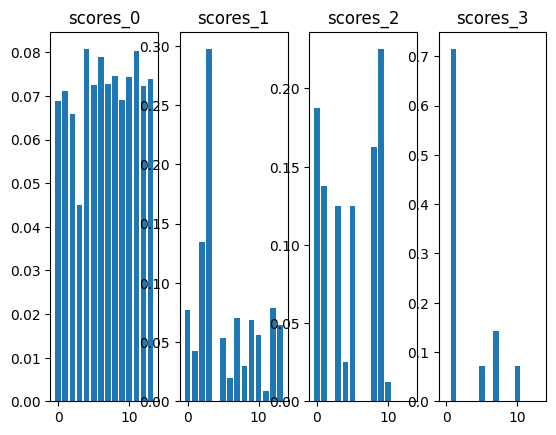

In [16]:
import matplotlib.pyplot as plt 

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'scores_{i}')
    plt.bar(x, medpix_labels_prob[f'scores_{i}'])

위에서 1이 positive token